In [237]:
import os
import operator

import pandas as pd
import numpy as np
import nltk

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, jaccard_score

from skimage import data, io, transform
from skimage import img_as_ubyte

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing

In [30]:
DF_PATH = 'goodreads-best-books/'
IMAGES_PATH = 'goodreads-best-books/images/images/'

In [31]:
books = pd.read_csv(DF_PATH + 'book_data.csv', encoding='utf8')
print(books.shape)
books.head()

(54301, 12)


,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [32]:
# Copy index as image name to maintain access to appropriate image file
books['img_name'] = books.index

In [33]:
# Drop extra columns
to_drop = ['book_desc', 'book_isbn', 'book_edition', 'book_format', 'book_pages', 'book_rating_count', 'book_review_count', 'book_rating']
books.drop(to_drop, inplace=True, axis=1)

# Move book_title column to after book_author
headers = books.columns.tolist()
headers = ['book_authors', 'book_title', 'image_url', 'img_name', 'genres']
books = books[headers]

# Remove extra author names
books['book_authors'] = books['book_authors'].str.split('|').str[0]

# Split label into list of genres
books['genres'] = books['genres'].str.split('|')

# Remove empty genres and book_desc
books = books[books['genres'].notna()]

# Remove rows with images with errors
books = books[-books['img_name'].isin(['2833', '17637', '33060', '44763', '49439'])]

# Remove rows with missing images
books = books[books['image_url'].notnull()].reset_index(drop = True)
books.drop(['image_url'], inplace=True, axis=1)

books.shape

(50674, 4)

In [34]:
# Ensure image files and dataframe are synced
file_names = list(books['img_name'].apply(lambda row: str(row) + '.jpg'))
print("Matching image names: {}".format(len(set(file_names).intersection(list(os.listdir(IMAGES_PATH))))))

Matching image names: 50674


In [36]:
# Remove Fiction and Nonfiction since they are not considered genres
books['genres'] = books.genres.apply(lambda x: [i for i in x if i not in ['Fiction', 'Nonfiction']])

In [37]:
books.head()

,book_authors,book_title,img_name,genres
0,Suzanne Collins,The Hunger Games,0,"[Young Adult, Science Fiction, Dystopia, Fanta..."
1,J.K. Rowling,Harry Potter and the Order of the Phoenix,1,"[Fantasy, Young Adult]"
2,Harper Lee,To Kill a Mockingbird,2,"[Classics, Historical, Historical Fiction, Aca..."
3,Jane Austen,Pride and Prejudice,3,"[Classics, Romance]"
4,Stephenie Meyer,Twilight,4,"[Young Adult, Fantasy, Romance, Paranormal, Va..."


### Label Distribution

In [38]:
genres = [item for sublist in list(books.genres) for item in sublist]
all_genres = nltk.FreqDist(genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

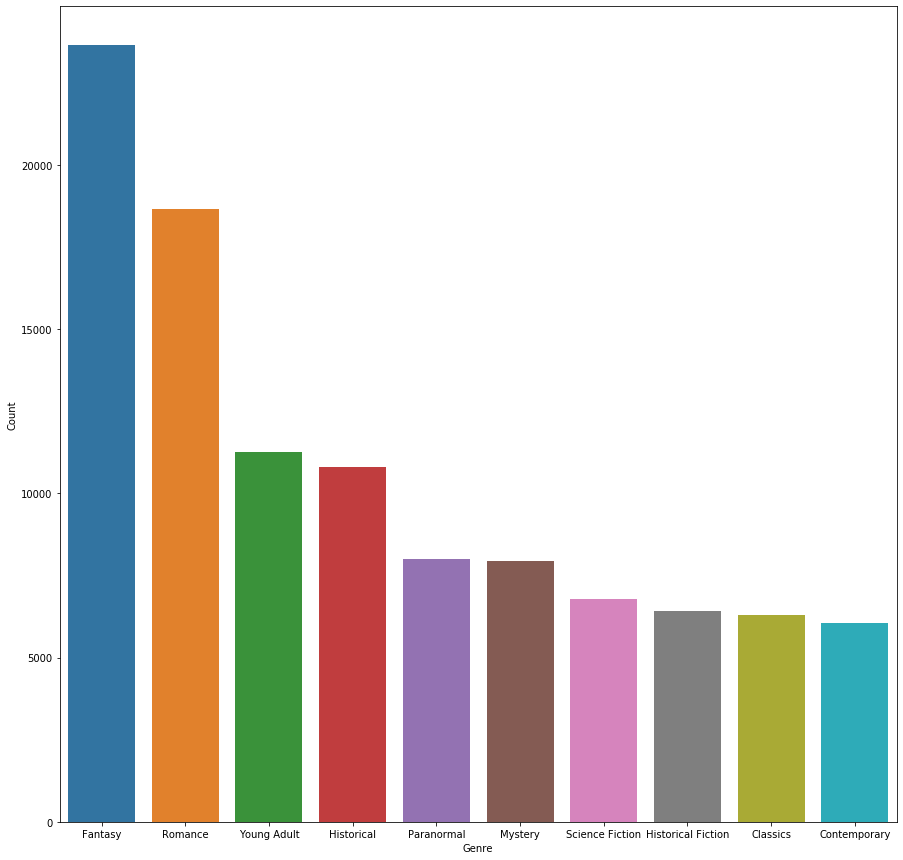

In [39]:
g = all_genres_df.nlargest(columns="Count", n = 10)
plt.figure(figsize=(15,15))
ax = sns.barplot(data=g, x="Genre", y="Count")
ax.set(ylabel = 'Count')
plt.show()

In [40]:
# List of top 10 occuring genres
all_genres_df = all_genres_df.sort_values('Count', ascending=False)
top_genres = list(all_genres_df['Genre'][:10])

In [41]:
print(top_genres)

['Fantasy', 'Romance', 'Young Adult', 'Historical', 'Paranormal', 'Mystery', 'Science Fiction', 'Historical Fiction', 'Classics', 'Contemporary']


In [42]:
# Filter genres not in top 10
books['genres'] = books.genres.apply(lambda x: [i for i in x if i in top_genres])

In [43]:
# Limit to first three labels
books['genres'] = books['genres'].str[:3]

In [44]:
# Remove rows with empty genres (books with genres not in top 10)
books = books[books['genres'].map(lambda d: len(d)) > 0]

In [45]:
books.shape

(37796, 4)

In [120]:
# Use MLB to make multiple binary labels.
s = books['genres']

mlb = MultiLabelBinarizer()

y = np.array(pd.DataFrame(mlb.fit_transform(s),columns=[top_genres], index=books.index)).astype(np.float32)
y

array([[0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [121]:
y.shape

(37796, 10)

## Image processing

In [65]:
# Store resized images as arrays (Height, Width, Channels) to be our features
X = []

height = 100
width = 60
channels = 3

for i in tqdm(list(books['img_name'])):
    path = IMAGES_PATH + str(i) + '.jpg'
    img = image.load_img(path, target_size=(height, width, channels))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

100%|██████████| 37796/37796 [02:29<00:00, 252.80it/s]


In [66]:
X = np.array(X)

In [67]:
X.shape

(37796, 100, 60, 3)

In [122]:
y.shape

(37796, 10)

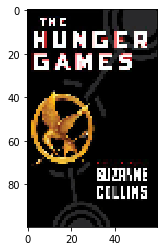

In [69]:
# Show rescaled book cover
plt.imshow(X[0])

### Augmentation

In [123]:
datagen = image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest',
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
)

<Figure size 432x288 with 0 Axes>

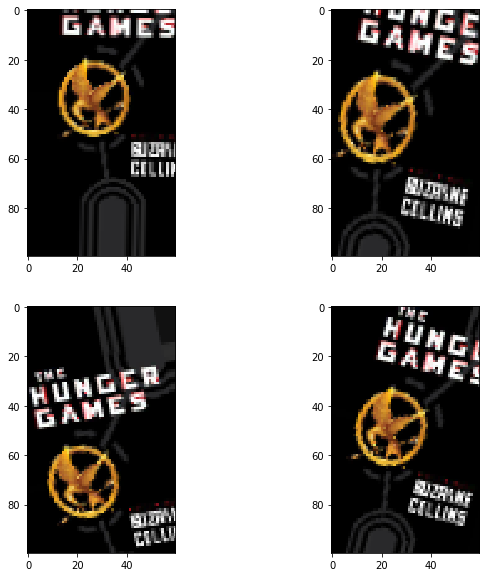

In [124]:
# visualize data augmentations
plt.clf()

img = X[0]
img = img.reshape((1,) + img.shape)
plt.figure(figsize=(10,10))

i = 0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

# CNN

In [125]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.15)

In [126]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 13, test_size = 0.20)

In [137]:
# datagen.fit(X_train)

train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=128)


# do not augment validation data
test_datagen = image.ImageDataGenerator()

validation_generator = test_datagen.flow(
    X_val,
    y_val,
    batch_size=128)

In [138]:
POS_WEIGHT = 10 

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tf.convert_to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [207]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='sigmoid'))
model.compile(loss=weighted_binary_crossentropy,
             optimizer=Adam(),
             metrics=['binary_accuracy'])

In [208]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 98, 58, 32)        896       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 49, 29, 32)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 49, 29, 32)        128       
_________________________________________________________________
dropout_28 (Dropout)         (None, 49, 29, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 47, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 23, 13, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 21, 11, 128)     

In [209]:
history = model.fit(
    train_generator,
    steps_per_epoch=int(len(X_train)/128),
    epochs= 125,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Train for 200 steps, validate for 50 steps
Epoch 1/125


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


200/200 [==============================] - 88s 442ms/step - loss: 1.6455 - binary_accuracy: 0.3919 - val_loss: 1.6134 - val_binary_accuracy: 0.3662
Epoch 2/125
200/200 [==============================] - 88s 438ms/step - loss: 1.5148 - binary_accuracy: 0.3590 - val_loss: 1.5434 - val_binary_accuracy: 0.3621
Epoch 3/125
200/200 [==============================] - 88s 441ms/step - loss: 1.4971 - binary_accuracy: 0.3734 - val_loss: 1.5179 - val_binary_accuracy: 0.4012
Epoch 4/125
200/200 [==============================] - 88s 441ms/step - loss: 1.4869 - binary_accuracy: 0.3858 - val_loss: 1.4815 - val_binary_accuracy: 0.3688
Epoch 5/125
200/200 [==============================] - 88s 438ms/step - loss: 1.4778 - binary_accuracy: 0.3922 - val_loss: 1.5167 - val_binary_accuracy: 0.4327
Epoch 6/125
200/200 [==============================] - 89s 444ms/step - loss: 1.4698 - binary_accuracy: 0.4020 - val_loss: 1.4537 - val_binary_accuracy: 0.4354
Epoch 7/125
200/200 [==============================]

200/200 [==============================] - 87s 435ms/step - loss: 1.3311 - binary_accuracy: 0.5094 - val_loss: 1.4247 - val_binary_accuracy: 0.5400
Epoch 53/125
200/200 [==============================] - 88s 438ms/step - loss: 1.3294 - binary_accuracy: 0.5107 - val_loss: 1.4040 - val_binary_accuracy: 0.5234
Epoch 54/125
200/200 [==============================] - 87s 435ms/step - loss: 1.3273 - binary_accuracy: 0.5094 - val_loss: 1.4197 - val_binary_accuracy: 0.5325
Epoch 55/125
200/200 [==============================] - 87s 436ms/step - loss: 1.3341 - binary_accuracy: 0.5062 - val_loss: 1.3781 - val_binary_accuracy: 0.5154
Epoch 56/125
200/200 [==============================] - 87s 436ms/step - loss: 1.3217 - binary_accuracy: 0.5150 - val_loss: 1.3982 - val_binary_accuracy: 0.5169
Epoch 57/125
200/200 [==============================] - 88s 438ms/step - loss: 1.3232 - binary_accuracy: 0.5144 - val_loss: 1.4176 - val_binary_accuracy: 0.5353
Epoch 58/125
200/200 [=========================

Epoch 103/125
200/200 [==============================] - 85s 425ms/step - loss: 1.2543 - binary_accuracy: 0.5561 - val_loss: 1.4690 - val_binary_accuracy: 0.5592
Epoch 104/125
200/200 [==============================] - 85s 424ms/step - loss: 1.2588 - binary_accuracy: 0.5553 - val_loss: 1.4780 - val_binary_accuracy: 0.5512
Epoch 105/125
200/200 [==============================] - 85s 425ms/step - loss: 1.2590 - binary_accuracy: 0.5536 - val_loss: 1.4321 - val_binary_accuracy: 0.5580
Epoch 106/125
200/200 [==============================] - 86s 431ms/step - loss: 1.2566 - binary_accuracy: 0.5557 - val_loss: 1.4301 - val_binary_accuracy: 0.5665
Epoch 107/125
200/200 [==============================] - 86s 431ms/step - loss: 1.2537 - binary_accuracy: 0.5570 - val_loss: 1.4642 - val_binary_accuracy: 0.5722
Epoch 108/125
200/200 [==============================] - 85s 426ms/step - loss: 1.2547 - binary_accuracy: 0.5565 - val_loss: 1.4922 - val_binary_accuracy: 0.5662
Epoch 109/125
200/200 [=====

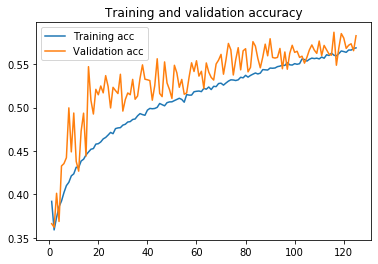

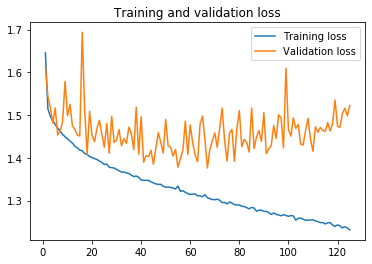

In [210]:
# plot error curves
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [252]:
predictions = model.predict(X_test)

In [253]:
def show_example(id):
    plt.imshow(X_test[id])
    actual_labels = np.nonzero(y_test[id])[0]
    label_count = len(actual_labels)
    top_predictions = np.argsort(-predictions[id])[:label_count]
    sorted_genres = sorted(top_genres)

    print("Prediction labels: " + ", ".join([sorted_genres[index] + ": " + str(predictions[id][index]) for index in top_predictions]))
    print("Actual labels: " + ", ".join([sorted_genres[index] for index in actual_labels]))
    print("Accuracy: ", len(np.intersect1d(top_predictions, actual_labels))/label_count)

Prediction labels: Fantasy: 0.90330344, Science Fiction: 0.7726756
Actual labels: Fantasy, Science Fiction
Accuracy:  1.0


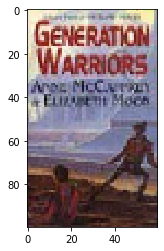

In [344]:
show_example(20)

In [345]:
predictions[20]

array([0.62151927, 0.05066258, 0.90330344, 0.51236516, 0.43106022,
       0.7533179 , 0.25256532, 0.3024002 , 0.7726756 , 0.5346045 ],
      dtype=float32)

In [369]:
# Accuracy takes the number of actual labels (1-3) and compares them with the top ranked predicted labels
# Ex: A book has three labels, the three highest predicted labels are selected and compared. 
# The accuracy for that book is the percentage of correct labels. For each label that wasn't predicted,
# a closeness value is added to the row accuracy.
# The overall accuracy is the average of all books.

binary_predictions = []

accuracy = 0.0
for i in range(y_test.shape[0]):
    actual_labels = np.nonzero(y_test[i])[0]
    label_count = len(actual_labels)
    
    top_predictions = np.argsort(-predictions[i])[:label_count]

    row_accuracy = len(np.intersect1d(top_predictions, actual_labels))/label_count
    accuracy += row_accuracy
    
    binary_predictions.append([0 if k not in list(top_predictions) else 1 for k in range(10)])
    
accuracy = accuracy/y_test.shape[0]
accuracy

0.45023515579071127

In [339]:
hamming_loss(y_test, binary_predictions)

0.19580246913580246

In [340]:
jaccard_score(y_test, binary_predictions, average='samples')

0.3916637272192827

In [367]:
jaccard_score([0, 1, 1], [1, 1, 0])

0.3333333333333333

10957

In [411]:
def show_random_sample():
    id = random.choice(range(len(X)))
    guess = model.predict(np.array([X[id]]))[0]
    plt.imshow(X[id])
    actual_labels = np.nonzero(y[id])[0]
    label_count = len(actual_labels)
    top_predictions = np.argsort(-guess)[:label_count]
    sorted_genres = sorted(top_genres)

    print("Prediction labels: " + ", ".join([sorted_genres[index] + ": " + str(guess[index]) for index in top_predictions]))
    print("Actual labels: " + ", ".join([sorted_genres[index] for index in actual_labels]))
    print("Accuracy: ", len(np.intersect1d(top_predictions, actual_labels))/label_count)

Prediction labels: Fantasy: 0.92341477, Young Adult: 0.86143136
Actual labels: Contemporary, Young Adult
Accuracy:  0.5


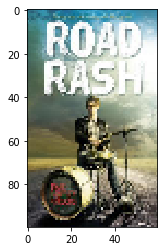

In [426]:
show_random_sample()